# Weather forecasting with PySpark

## Big Data Computing final project - A.Y. 2020-2021

Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author

Andrea Gasparini - [gasparini.1813486@studenti.uniroma1.it](mailto:gasparini.1813486@studenti.uniroma1.it)

In this Notebook I am addressing **weather forecasting** with _Machine Learning_ and _Big Data_ tools, in order to show whether is possible to make valuable predictions of metereological conditions only based on previously seen meteorological data. The classification goal is therefore, given a set of weather measurements, to predict which meteorological condition should occur.

The dataset I am using comes from [Kaggle](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) and contains hourly weather measurements data of **36** cities, collected from 2012 to 2017. This 5 years of data result in approximately **45.000** measurements (for each city) of temperature, humidity, air pressure and the like.

In addition to **PySpark**, I am going to make wide us of [Koalas](https://github.com/databricks/koalas) instead of **Pandas** for data analysis and manipulation. **Koalas** is a library that implements the same DataFrame API of Pandas but on top of **Apache Spark**, having so the advantages and simplicity of the former among with the distributed nature of the latter.

Another advantage of using Koalas is the possibility to switch from one type of `DataFrame` to another "for free" (it is almost immediate) with the `to_spark()` and `to_koalas()` methods.

## Define some global constants

In [0]:
DATASET_PATH: str = 'dbfs:/bdc-2020-21/datasets/historical-hourly-weather/'
MODELS_PATH: str = 'dbfs:/bdc-2020-21/models/historical-hourly-weather/'

RANDOM_SEED: int = 42
  
SLOW_OPERATIONS: bool = True
  
# True to save the computation of datataset preprocessing, fitted pipelines and trained models to the filesystem
SAVE_COMPUTATIONS: bool = True
  
# True to load the sampled dataset from the filesystem, False to compute it from the raw one
LOAD_SAMPLED_DATASET: bool = True
SAMPLED_DATASET_PATH: str = f'{DATASET_PATH}aggregated_sampled_weather_measurements.csv'
  
# True to load the encoding pipeline from the filesystem, False to compute it from scratch
LOAD_ECONDING_PIPELINE: bool = True
ENCODING_PIPELINE_PATH: str = f'{MODELS_PATH}data_encoder'

# True to load pretrained models from the filesystem, False to compute them from scratch
LOAD_PRETRAINED_MODELS: bool = True
RANDOM_FOREST_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest'
RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest_cv'
LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH: str = f'{MODELS_PATH}log_reg_cv'

# necessary due to DataBricks community edition limits (training on a dataframe larger than this threshold causes an Internal Server Error)
MAX_TRAIN_SIZE: int = 999_999

## Import PySpark packages and other dependencies

In [0]:
import pyspark
import numpy as np
import databricks.koalas as ks
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel

from typing import *

## Dataset initialization

### Download the dataset

Original source: [kaggle.com/selfishgene/historical-hourly-weather-data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data)

In [0]:
%sh
wget --no-verbose https://github.com/andrea-gasparini/big-data-weather-forecasting/blob/master/dataset/historical-hourly-weather-dataset.zip -O /tmp/dataset.zip
unzip -u /tmp/dataset.zip -d /tmp/dataset

2021-06-13 15:45:53 URL:https://github.com/andrea-gasparini/big-data-weather-forecasting/blob/master/dataset/historical-hourly-weather-dataset.zip [12556386] -> "/tmp/dataset.zip" [1]
Archive: /tmp/dataset.zip
 inflating: /tmp/dataset/city_attributes.csv 
 inflating: /tmp/dataset/humidity.csv 
 inflating: /tmp/dataset/pressure.csv 
 inflating: /tmp/dataset/temperature.csv 
 inflating: /tmp/dataset/weather_description.csv 
 inflating: /tmp/dataset/wind_direction.csv 
 inflating: /tmp/dataset/wind_speed.csv

### Move the dataset from Databricks local driver node's file system to DBFS

In [0]:
for file in dbutils.fs.ls('file:/tmp/dataset'):
    dbutils.fs.mv(file.path, f'{DATASET_PATH}{file.name}')

In [0]:
%fs ls /bdc-2020-21/datasets/historical-hourly-weather

path,name,size
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/aggregated_sampled_weather_measurements.csv/,aggregated_sampled_weather_measurements.csv/,0
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/city_attributes.csv,city_attributes.csv,1614
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/humidity.csv,humidity.csv,9075077
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/pressure.csv,pressure.csv,12155911
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/temperature.csv,temperature.csv,13971171
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/weather_description.csv,weather_description.csv,21858089
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/wind_direction.csv,wind_direction.csv,10171003
dbfs:/bdc-2020-21/datasets/historical-hourly-weather/wind_speed.csv,wind_speed.csv,7457531


### Load dataset into Koalas `DataFrame` objects

In [0]:
weather_conditions_df = ks.read_csv(f'{DATASET_PATH}weather_description.csv')
humidity_df = ks.read_csv(f'{DATASET_PATH}humidity.csv')
pressure_df = ks.read_csv(f'{DATASET_PATH}pressure.csv')
temperature_df = ks.read_csv(f'{DATASET_PATH}temperature.csv')
city_attributes_df = ks.read_csv(f'{DATASET_PATH}city_attributes.csv')
wind_direction_df = ks.read_csv(f'{DATASET_PATH}wind_direction.csv')
wind_speed_df = ks.read_csv(f'{DATASET_PATH}wind_speed.csv')

### Dataset shape and schema

The raw dataset downloaded from kaggle is composed of 7 different `.csv` files:
- `city_attributes.csv` contains geographical information about the different cities for which there are weather measurements;
- `weather_description.csv` contains the textual description of the weather conditions, where each column refers to a different city and each row refers to a specific `datetime` in which the weather condition occurred;
- Each one of the other 5 csv follows the same structure as `weather_description.csv` and contains the measurements of the following metrics: `humidity`,  `pressure`, `temperature`, `wind_direction`, `wind_speed`

Except for `city_attributes.csv`, all the other files contains about **45.000** records of hourly weather measurements, that multiplied by the **36** cities results in approximately **1.500.000** records.

In [0]:
def print_dataframe_shape(dataframe: Union[DataFrame, ks.DataFrame]) -> None:
    
    if isinstance(dataframe, ks.DataFrame): dataframe = dataframe.to_spark()

    rows_count = dataframe.count()
    columns_count = len(dataframe.columns)

    print(f'The shape of the dataset is {rows_count} rows by {columns_count} columns', end='\n\n')

#### `city_attributes.csv`

In [0]:
print_dataframe_shape(city_attributes_df)

The shape of the dataset is 36 rows by 4 columns

In [0]:
city_attributes_df.spark.print_schema()

root
-- City: string (nullable = true)
-- Country: string (nullable = true)
-- Latitude: double (nullable = true)
-- Longitude: double (nullable = true)

In [0]:
city_attributes_df.head(5)

Out[247]:

,City,Country,Latitude,Longitude
0,Vancouver,Canada,49.249660,-123.119339
1,Portland,United States,45.523449,-122.676208
2,San Francisco,United States,37.774929,-122.419418
3,Seattle,United States,47.606209,-122.332069
4,Los Angeles,United States,34.052231,-118.243683


#### `weather_description.csv`

In [0]:
print_dataframe_shape(weather_conditions_df)

The shape of the dataset is 45253 rows by 37 columns

In [0]:
weather_conditions_df.spark.print_schema()

root
-- datetime: string (nullable = true)
-- Vancouver: string (nullable = true)
-- Portland: string (nullable = true)
-- San Francisco: string (nullable = true)
-- Seattle: string (nullable = true)
-- Los Angeles: string (nullable = true)
-- San Diego: string (nullable = true)
-- Las Vegas: string (nullable = true)
-- Phoenix: string (nullable = true)
-- Albuquerque: string (nullable = true)
-- Denver: string (nullable = true)
-- San Antonio: string (nullable = true)
-- Dallas: string (nullable = true)
-- Houston: string (nullable = true)
-- Kansas City: string (nullable = true)
-- Minneapolis: string (nullable = true)
-- Saint Louis: string (nullable = true)
-- Chicago: string (nullable = true)
-- Nashville: string (nullable = true)
-- Indianapolis: string (nullable = true)
-- Atlanta: string (nullable = true)
-- Detroit: string (nullable = true)
-- Jacksonville: string (nullable = true)
-- Charlotte: string (nullable = true)
-- Miami: string (nullable = true)
-- Pittsburgh: string (nullable = true)
-- Toronto: string (nullable = true)
-- Philadelphia: string (nullable = true)
-- New York: string (nullable = true)
-- Montreal: string (nullable = true)
-- Boston: string (nullable = true)
-- Beersheba: string (nullable = true)
-- Tel Aviv District: string (nullable = true)
-- Eilat: string (nullable = true)
-- Haifa: string (nullable = true)
-- Nahariyya: string (nullable = true)
-- Jerusalem: string (nullable = true)

In [0]:
weather_conditions_df[weather_conditions_df.columns[:5]].head(5)

Out[250]:

,datetime,Vancouver,Portland,San Francisco,Seattle
0,2012-10-01 12:00:00,None,None,None,None
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear


## Dataset preprocessing

### Columns constants

Here we are defining some constants regarding the dataset columns which we are going to use throughout this notebook.

In [0]:
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

### Create a single `DataFrame` that includes all data from the others

As we have seen, the dataset is not provided in the best possible format for Machine Learning purposes, in fact the best solution would be to have a single `DataFrame` object which includes all the information about the hourly measurements, with one column for each metric, one column for the weather condition and some columns for the information about where the measurement has been made (city, geographical position, etc).

In [0]:
def filter_dataframe_by_city_column(dataframe: ks.DataFrame,
                                    city_name: str,
                                    new_column_name: str) -> DataFrame:
    '''
    Args:
        - dataframe: a `DataFrame` with a datetime column and n cities columns,
                     where the records are the related hourly measurements
        - city_name: city name between the ones in the dataframe
        - new_column_name: name to replace the city name
        
    Returns: 
        a new `DataFrame` with:
            - the datetime column
            - a single column of measurements related to the `city_name`
              and renamed as `new_column_name`
    '''
    return dataframe.to_spark() \
        .withColumn(new_column_name, col(city_name)) \
        .select([DATETIME_COL, new_column_name])

In [0]:
def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    '''
    Args:
        - dataframse: a list of `DataFrame` to be joined
        - column_name: the column over which the records should be joined
        
    Returns:
        a new dataframes resulting from the join of all the dataframes
        over the `column_name` column
    '''
    joined_df = dataframes[0]

    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    return joined_df

In [0]:
weather_measurements_df = None

# Iterate over all the records in the cities `DataFrame`
for index, row in city_attributes_df.iterrows():    

    city = row.City
    country = row.Country
    latitude = row.Latitude
    longitude = row.Longitude

    # Compute a list of `DataFrame`, one for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Compute a `DataFrame` that includes all the data about the measurements in the city
    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the `DataFrame` with the ones computed in the previous iterations
    weather_measurements_df = weather_measurements_df.union(joined_df) if weather_measurements_df is not None else joined_df

#### Check the shape of the newly created dataset

In [0]:
print_dataframe_shape(weather_measurements_df)

The shape of the dataset is 1629108 rows by 11 columns

#### Print out the new schema

In [0]:
weather_measurements_df.printSchema()

root
-- datetime: string (nullable = true)
-- humidity: double (nullable = true)
-- pressure: double (nullable = true)
-- temperature: double (nullable = true)
-- wind_direction: double (nullable = true)
-- wind_speed: double (nullable = true)
-- weather_condition: string (nullable = true)
-- city: string (nullable = false)
-- country: string (nullable = false)
-- latitude: double (nullable = false)
-- longitude: double (nullable = false)

#### Display the first 5 rows

In [0]:
if SLOW_OPERATIONS: weather_measurements_df.show(5)

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
 datetime|humidity|pressure| temperature|wind_direction|wind_speed|weather_condition| city|country|latitude| longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
2012-10-01 12:00:00| null| null| null| null| null| null|Vancouver| Canada|49.24966|-123.119339|
2012-10-01 13:00:00| 76.0| null| 284.63| 0.0| 0.0| mist|Vancouver| Canada|49.24966|-123.119339|
2012-10-01 14:00:00| 76.0| null| 284.62904131| 6.0| 0.0| broken clouds|Vancouver| Canada|49.24966|-123.119339|
2012-10-01 15:00:00| 76.0| null|284.626997923| 20.0| 0.0| broken clouds|Vancouver| Canada|49.24966|-123.119339|
2012-10-01 16:00:00| 77.0| null|284.624954535| 34.0| 0.0| broken clouds|Vancouver| Canada|49.24966|-123.119339|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
only showing top 5 rows

#### Summary of descriptive statistics

In [0]:
if SLOW_OPERATIONS: weather_measurements_df.describe().to_koalas().transpose()

### Clean the dataset from measurements with missing metrics

As we have seen, the measurements in the dataset can have missing values for some of the metrics. In order to solve this problem there are two options:
- drop all the rows that contain null values
- replace null values with representative ones (e.g. their mean)

Since we have a huge amount of data we can safely drop the null rows and still have enough data to effectively train a Machine Learning model, moreover, keeping only real measurements in the dataset will certainly avoid any eventual "wrong influence" in the predictions caused by the artificial ones.

In [0]:
if SLOW_OPERATIONS:
    for c in weather_measurements_df.columns:
        print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

Missing values of column `datetime` count: 0
Missing values of column `humidity` count: 28651
Missing values of column `pressure` count: 16680
Missing values of column `temperature` count: 8030
Missing values of column `wind_direction` count: 7975
Missing values of column `wind_speed` count: 7993
Missing values of column `weather_condition` count: 7955
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0

In [0]:
not_null_weather_measurements_df = weather_measurements_df.dropna()

### Aggregation of weather condition classes

The target classes for our weather forecasting classification task are too sparse in the original dataset.
In fact we have **54** different weather conditions, where some occur only very few times and a lot of them are really similar between each other.

For example all the following conditions essentially tell us that **there is a thunderstorm** and so they could be classified as the same metheorological condition:
- _thunderstorm with light drizzle_
- _thunderstorm with rain_
- _thunderstorm with light rain_

In order to obtain a better set of target classes it is necessary to preprocess the dataset and aggregate some of them.

In [0]:
if SLOW_OPERATIONS: not_null_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show(truncate=False)

+----------------------------+------+
weather_condition |count |
+----------------------------+------+
fog |16185 |
very heavy rain |1001 |
proximity shower rain |2339 |
few clouds |133685|
heavy shower snow |336 |
light rain |127364|
light intensity drizzle |8048 |
light intensity shower rain |3633 |
broken clouds |167102|
overcast clouds |133778|
light snow |14368 |
scattered clouds |143277|
thunderstorm with heavy rain|396 |
thunderstorm with light rain|1179 |
heavy intensity rain |14075 |
moderate rain |43172 |
light intensity drizzle rain|41 |
sky is clear |641577|
snow |3156 |
light shower snow |998 |
+----------------------------+------+
only showing top 20 rows

#### Aggregate the weather conditions in a dictionary

We are going to have **6** aggregated classes from the original **54**:
- thunderstorm
- rainy
- snowy
- cloudy
- foggy
- sunny

In [0]:
def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        a dictionary that goes from the original weather condition name to one among the following:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
    '''
    
    weather_conditions_dict = dict()
  
    for weather_condition in weather_conditions:
  
        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'cloud' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'
            
    return weather_conditions_dict

In [0]:
weather_conditions_all = not_null_weather_measurements_df \
    .select(WEATHER_CONDITION_COL).distinct() \
    .to_koalas().to_numpy().reshape(-1)

In [0]:
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

#### Replace all the weather conditions in the `DataFrame` with the aggregated ones

In [0]:
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)

#### Remove all the records that contain other weather conditions

In [0]:
WEATHER_CONDITIONS = set(weather_conditions_dict.values())

weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(WEATHER_CONDITIONS))

In [0]:
if SLOW_OPERATIONS: weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+------+
weather_condition| count|
+-----------------+------+
 rainy|202725|
 snowy| 21283|
 sunny|641577|
 cloudy|577842|
 thunderstorm| 10852|
 foggy|138707|
+-----------------+------+

### Undersampling procedure

After the weather condition classes aggregation we can easily notice a huge class imbalance, i.e. some classes have a tiny fraction of the total number of instances.

It is therefore necessary to process again the imbalanced data before feed them into a classifier in order to avoid it to be more sensitive to detecting the majority classes and less sensitive to the minority classes.
Not taking care of this issue would make the classification output biased, usually resulting in always predicting the majority classes.

A simple but effective procedure to deal with the imbalancing is **undersampling**, which consists in dropping a fraction of the majority classes to match the occurrences of the minority one.

In [0]:
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    '''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_COL`
        - class_name: the class name to count the occurences of
        
    Returns:
        the total number of `class_name` occurences inside `dataframe`
    '''
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

In [0]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_COL`
        
    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurences of the minority class
    '''

    rainy_cnt = count_weather_condition_occurrences(dataframe, 'rainy')
    snowy_cnt = count_weather_condition_occurrences(dataframe, 'snowy')
    sunny_cnt = count_weather_condition_occurrences(dataframe, 'sunny')
    foggy_cnt = count_weather_condition_occurrences(dataframe, 'foggy')
    cloudy_cnt = count_weather_condition_occurrences(dataframe, 'cloudy')
    thunderstorm_cnt = count_weather_condition_occurrences(dataframe, 'thunderstorm')

    minority_class_cnt = np.min([rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt, foggy_cnt, thunderstorm_cnt])

    return {
        'rainy': minority_class_cnt / rainy_cnt,
        'snowy': minority_class_cnt / snowy_cnt,
        'sunny': minority_class_cnt / sunny_cnt,
        'foggy': minority_class_cnt / foggy_cnt,
        'cloudy': minority_class_cnt / cloudy_cnt,
        'thunderstorm': minority_class_cnt / thunderstorm_cnt
    }

#### Create the undersampled dataset

Since computing the number of occurrences of each weather condition class take some time, we can directly load the previously computed dataset from the filesystem setting `LOAD_SAMPLED_DATASET = True` at the beginning of this Notebook.

In [0]:
sampled_weather_measurements_df = ks.read_csv(SAMPLED_DATASET_PATH).to_spark() if LOAD_SAMPLED_DATASET \
                                  else not_null_weather_measurements_df.sampleBy(WEATHER_CONDITION_COL,
                                                                                 fractions=get_undersampling_fracs(not_null_weather_measurements_df),
                                                                                 seed=RANDOM_SEED)

#### Save the undersampled dataset to the filesystem

In [0]:
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

In [0]:
sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+-----+
weather_condition|count|
+-----------------+-----+
 rainy| 8373|
 snowy| 8622|
 sunny| 8656|
 cloudy| 8644|
 thunderstorm| 8553|
 foggy| 8581|
+-----------------+-----+

#### Summary of descriptive statistics

In [0]:
sampled_weather_measurements_df.describe().to_koalas().transpose()

Out[273]:

,0,1,2,3,4
summary,count,mean,stddev,min,max
datetime,51429,None,None,2012-10-01 14:00:00,2017-11-30 00:00:00
humidity,51429,73.35688035933033,20.63399620451051,5.0,100.0
pressure,51429,1017.105601897762,13.325849842166008,803.0,1100.0
temperature,51429,286.62986694770956,12.068790803267767,243.62,317.35
wind_direction,51429,183.87932878337125,103.66481323872385,0.0,360.0
wind_speed,51429,3.1757957572575783,2.2916893461124297,0.0,35.0
weather_condition,51429,None,None,cloudy,thunderstorm
city,51429,None,None,Albuquerque,Vancouver
country,51429,None,None,Canada,United States


### Split the dataset in Train and Test subsets

In [0]:
train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [0]:
# necessary due to DataBricks limits (training on a dataframe larger than this threshold causes an Internal Server Error)
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [0]:
print(f'Train set size:  {train_df.count()} instances')
print(f'Test set size:   {test_df.count()} instances')

Train set size: 41346 instances
Test set size: 10083 instances

## Machine learning pipeline

Here we are defining some constants for the features and other columns that we are going to need in the pipelines for training and testing purposes.

Note that the categorical features list, i.e. the features that are not numerical values, is an empty one. This is due to the fact that the only ones in this task are `city` and `country` that are obviously redundant and do not add any information with respect to `latitude` and `longitude`.

In [0]:
NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL]

CATEGORICAL_FEATURES = []

TARGET_VARIABLE_COL = WEATHER_CONDITION_COL
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

LABEL_COL = 'label'
PREDICTION_COL = 'prediction'

FEATURES_COL = 'features'
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

In [0]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    
    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    model.write().overwrite().save(path)

### Data encoding pipeline

This pipeline is responsible of encoding a `DataFrame` into a suitable format for a Machine Learning model and it is composed of the following steps:
- a `StringIndexer` encodes the target column of labels into a column of label indices
- one `StringIndexer` for each categorical feature
- a `OneHotEncoder` maps the indexed categorical features to a binary vector with at most one single one-value, this encoder will keep any unseen label in the future
- a `VectorAssembler` combines all the features (both one-hot-encoded categorical and numerical) into a single vector
- a `StandardScaler` creates a second features column according to unit standard deviation, optionally centering the data with mean before scaling

In [0]:
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    '''
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
    '''
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)
    
    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers], 
                            handleInvalid='keep')
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features    
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)
    
    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(dataframe)

    return transformer

#### Instantiate the encoding pipeline

Since also this computation takes some time, as we have already seen with the dataset, we can directly load the previously computed one from the filesystem setting `LOAD_ECONDING_PIPELINE = True` at the beginning of this Notebook.

In [0]:
data_encoder = PipelineModel.load(ENCODING_PIPELINE_PATH) if LOAD_ECONDING_PIPELINE \
               else encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

#### Save the encoding pipeline to the filesystem

In [0]:
if SAVE_COMPUTATIONS and not LOAD_ECONDING_PIPELINE:
    save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

#### Encode the Train and Test sets with the pipeline

In [0]:
encoded_train_df = data_encoder.transform(train_df)
encoded_test_df = data_encoder.transform(test_df)

#### Show the encoding pipeline result on the Train set

In [0]:
encoded_train_df.select([FEATURES_COL, SCALED_FEATURES_COL, LABEL_COL]).show(5)

+--------------------+--------------------+-----+
 features| scaled_features|label|
+--------------------+--------------------+-----+
[56.0,1018.0,293....|[2.71512994678049...| 0.0|
[47.0,1019.0,296....|[2.27876977676220...| 0.0|
[49.0,1014.0,294....|[2.37573870343293...| 5.0|
[39.0,1022.0,297....|[1.89089407007927...| 1.0|
[34.0,998.0,301.6...|[1.64847175340244...| 1.0|
+--------------------+--------------------+-----+
only showing top 5 rows

### A simple Random Forest model

Note that training a Machine Learning model could take up to several hours, so this simple Random Forest model, among with all the others in the Notebook, is going to be loaded from the filesystem.

Set `LOAD_PRETRAINED_MODELS = False` at the beginning of this Notebook to train all the models from scratch.

In [0]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

rnd_forest_model = RandomForestClassificationModel.load(RANDOM_FOREST_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)

#### Compute predictions on the Test set according to the trained model

In [0]:
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

#### Create a new column containing the predictions' labels

The model make predictions as numerical values, indexed following the `StringIndexer` at the first stage of the encoding pipeline. We can easily convert them back to string values with `IndexToString`.

In [0]:
from pyspark.ml.feature import IndexToString

predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [0]:
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

### Evaluation of model performance on the Test Set

In [0]:
def eval_predictions(predictions: DataFrame) -> None:
  
    from sklearn.metrics import precision_score, recall_score, accuracy_score

    labels = predictions.select(LABEL_COL).to_koalas().to_numpy()
    predictions = predictions.select(PREDICTION_COL).to_koalas().to_numpy()

    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(labels, predictions)    

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')

In [0]:
eval_predictions(rnd_forest_predictions)

Accuracy: 0.5137359912724387
Precision: 0.4913815767839824
Recall: 0.5140054118534055
F1-score: 0.5024389466076965

### Plot a confusion matrix of the model predictions on the Test set

A confusion matrix is an easy way to visualize the performance of a Machine Learning model. Each row of the matrix represents the number of instances (or the percentage if it is normalized) in the true class while each column represents the instances in a predicted class.

All the correct predictions are located in the diagonal of the matrix, which values essentially represent the **Recall** metric of each class. Thanks to this visualization it is easy to find in which class prediction the model is lacking most, since the prediction errors will be represented by values outside the diagonal.

In [0]:
def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given `DataFrame`
    
    Args:
        - predictions_df: a `DataFrame` that has at least a `TARGET_VARIABLE_COL` and a `PREDICTED_TARGET_VARIABLE_COL`
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    labels = predictions_df.select(TARGET_VARIABLE_COL).to_koalas().to_numpy()
    pedictions = predictions_df.select(PREDICTED_TARGET_VARIABLE_COL).to_koalas().to_numpy()

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, pedictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, pedictions)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

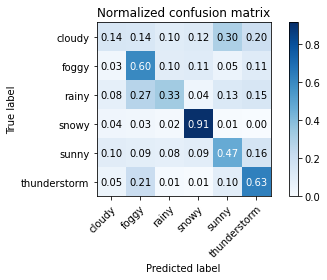

In [0]:
plot_confusion_matrix(rnd_forest_predictions, normalize=True)

### Save the model to the filesystem

In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

## Hyperparameters tuning

Here we define a pipeline that summarizes and includes all the steps that we have done so far:
- the previously defined data encoding pipeline
- a Machine Learning model instance
- a `IndexToString` that converts the numerical predictions in their label version

In addition we have a **K-Fold Cross Validation** step in order to tune some hyperparameters and to get a better estimation of the generalization performance of the model.

### Random Forest model

For the Random Forest model we have seen that without configuring any hyperparameter, we can still achieve decent results in predicting some classes.

Let's see whether tuning the **max depth** of the trees (`maxDepth`) and the **number of trees** (`numTrees`) can result in better overall performance.

In [0]:
def random_forest_pipeline(dataframe: DataFrame,
                           numerical_features: List[str],
                           categorical_features: List[str],
                           target_variable: str,
                           features_col: str,
                           with_std: bool = True,
                           with_mean: bool = False,
                           k_fold: int = 5) -> CrossValidatorModel:
  
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline
  
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    classifier = RandomForestClassifier(featuresCol=features_col, labelCol=LABEL_COL)
    
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for maxDepth and 3 values for numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [3, 5, 8]) \
        .addGrid(classifier.numTrees, [10, 50, 100]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
rnd_forest_cv_model = CrossValidatorModel.load(RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                      else random_forest_pipeline(train_df,
                                                  NUMERICAL_FEATURES,
                                                  CATEGORICAL_FEATURES,
                                                  TARGET_VARIABLE_COL,
                                                  FEATURES_COL)

In [0]:
rnd_forest_cv_model_obj = rnd_forest_cv_model.bestModel.stages[-2]._java_obj

print('Best model according to k-fold cross validation:')
print(f' - numTrees=[{rnd_forest_cv_model_obj.getNumTrees()}]')
print(f' - maxDepth=[{rnd_forest_cv_model_obj.getMaxDepth()}]')

Best model according to k-fold cross validation:
 - numTrees=[50]
 - maxDepth=[8]

In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(rnd_forest_cv_model, RANDOM_FOREST_CROSS_VALIDATION_MODEL_PATH)

In [0]:
rnd_forest_cv_predictions = rnd_forest_cv_model.transform(test_df)

In [0]:
eval_predictions(rnd_forest_cv_predictions)

Accuracy: 0.546365169096499
Precision: 0.527042400491183
Recall: 0.5469340629492113
F1-score: 0.5368040199386482

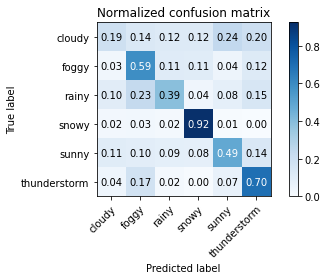

In [0]:
plot_confusion_matrix(rnd_forest_cv_predictions, normalize=True)

### Logistic Regression model

In [0]:
def logistic_regression_pipeline(dataframe: DataFrame,
                                 numerical_features: List[str],
                                 categorical_features: List[str],
                                 target_variable: str,
                                 features_col: str,
                                 with_std: bool = True,
                                 with_mean: bool = False,
                                 k_fold: int = 5) -> CrossValidatorModel:
  
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline
  
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    classifier = LogisticRegression(featuresCol=features_col, labelCol=LABEL_COL)
    
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    stages = [data_encoder, classifier, predictions_idx_to_str]

    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for regParam, 3 values for maxIter and 3 values for elasticNetParam,
    # this grid will have 3 x 3 x 3 = 12 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
        .addGrid(classifier.maxIter, [10, 100, 1000]) \
        .addGrid(classifier.regParam, [0.0, 0.05, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    cv_model = cross_val.fit(dataframe)

    return cv_model

In [0]:
log_reg_cv_model = CrossValidatorModel.load(LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else logistic_regression_pipeline(train_df,
                                                     NUMERICAL_FEATURES,
                                                     CATEGORICAL_FEATURES,
                                                     TARGET_VARIABLE_COL,
                                                     FEATURES_COL)

In [0]:
log_reg_cv_model_obj = log_reg_cv_model.bestModel.stages[-2]._java_obj

print('Best model according to k-fold cross validation:')
print(f' - regParam=[{log_reg_cv_model_obj.getRegParam()}]')
print(f' - elasticNetParam=[{log_reg_cv_model_obj.getElasticNetParam()}]')
print(f' - maxIter=[{log_reg_cv_model_obj.getMaxIter()}]')

Best model according to k-fold cross validation:
 - regParam=[0.0]
 - elasticNetParam=[0.0]
 - maxIter=[1000]

In [0]:
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(log_reg_cv_model, LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH)

In [0]:
log_reg_cv_predictions = log_reg_cv_model.transform(test_df)

In [0]:
eval_predictions(log_reg_cv_predictions)

Accuracy: 0.47733809382128334
Precision: 0.44390801747900444
Recall: 0.47705055766795074
F1-score: 0.45988293720560103

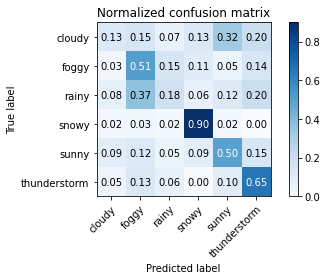

In [0]:
plot_confusion_matrix(log_reg_cv_predictions, normalize=True)

## Comparison with [OpenWeather](https://openweathermap.org/) forecasts

In the following, we make a comparison with the OpenWeather forecasts, obtained through their [free APIs](https://openweathermap.org/api).

Note that the weather measurements values that we are going to obtain are forecasts themselves and since our model is based on real measured values, it is very likely that we are not going to get the same performance as on the test set.

In [0]:
API_KEY = 'f8f8ac843645da14d66bb19cffacbaa1'
CITY_NAMES = ['Vancouver']

openweather_model = rnd_forest_cv_model

OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [0]:
def get_5_days_forecasts_df(city_name: str, api_key: str) -> ks.DataFrame:

    import requests
  
    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    res = requests.get(API_URL).json()

    coord = res['city']['coord']

    latitude = float(coord['lat'])
    longitude = float(coord['lon'])
    
    WeatherForecast = Row(DATETIME_COL,
                          HUMIDITY_COL,
                          PRESSURE_COL,
                          TEMPERATURE_COL,
                          WIND_DIRECTION_COL,
                          WIND_SPEED_COL,
                          TARGET_VARIABLE_COL,
                          CITY_COL,
                          LATITUDE_COL,
                          LONGITUDE_COL)

    forecasts = list()

    for forecast in res['list']:
      
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        datetime = forecast['dt_txt']
        
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        weather_condition = weather[0]['main']
        
        forecast_row = WeatherForecast(datetime,
                                       humidity,
                                       pressure,
                                       temperature,
                                       wind_direction,
                                       wind_speed,
                                       weather_condition,
                                       city_name,
                                       latitude,
                                       longitude)

        forecasts.append(forecast_row)
        
    return spark.createDataFrame(forecasts).to_koalas()

In [0]:
openweather_forecasts_df = ks.concat([get_5_days_forecasts_df(city_name, API_KEY) for city_name in CITY_NAMES])

In [0]:
weather_conditions = openweather_forecasts_df[TARGET_VARIABLE_COL].to_numpy()
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions)

In [0]:
openweather_forecasts_df = openweather_forecasts_df.to_spark().replace(weather_conditions_dict)

In [0]:
openweather_forecasts_df = openweather_forecasts_df.filter(openweather_forecasts_df[TARGET_VARIABLE_COL].isin(WEATHER_CONDITIONS))

In [0]:
openweather_forecasts_df.to_koalas().head(5)

Out[313]:

,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,latitude,longitude
0,2021-06-13 18:00:00,94.0,1011.0,287.56,73.0,1.70,rainy,Vancouver,49.2497,-123.1193
1,2021-06-13 21:00:00,94.0,1012.0,287.19,46.0,2.05,rainy,Vancouver,49.2497,-123.1193
2,2021-06-14 00:00:00,96.0,1013.0,286.82,65.0,2.10,rainy,Vancouver,49.2497,-123.1193
3,2021-06-14 03:00:00,91.0,1013.0,287.68,45.0,2.36,rainy,Vancouver,49.2497,-123.1193
4,2021-06-14 06:00:00,91.0,1013.0,287.13,107.0,1.36,rainy,Vancouver,49.2497,-123.1193


In [0]:
openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

In [0]:
openweather_forecasts_predictions \
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL)) \
    .select([DATETIME_COL, CITY_COL, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL]) \
    .to_koalas().head(15)

Out[321]:

,datetime,city,openweather_forecast,predicted_weather_condition
0,2021-06-13 18:00:00,Vancouver,rainy,rainy
1,2021-06-13 21:00:00,Vancouver,rainy,rainy
2,2021-06-14 00:00:00,Vancouver,rainy,rainy
3,2021-06-14 03:00:00,Vancouver,rainy,rainy
4,2021-06-14 06:00:00,Vancouver,rainy,rainy
5,2021-06-14 09:00:00,Vancouver,rainy,rainy
6,2021-06-14 12:00:00,Vancouver,rainy,rainy
7,2021-06-14 15:00:00,Vancouver,rainy,rainy
8,2021-06-14 18:00:00,Vancouver,rainy,rainy
9,2021-06-14 21:00:00,Vancouver,rainy,cloudy


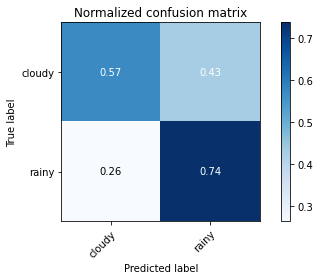

In [0]:
plot_confusion_matrix(openweather_forecasts_predictions, normalize=True)